# Handwritten Digits using Quadratic cost function

**Here, I am creating a Neural network from scratch and using Mean squared error as the loss function which will be able to recognise handwritten digits. The data used to train the model is MNIST dataset. I have also added L2 regularisation and some intelligent weights initialisation techniques to compare tge results at the end.**

**Importing the necessary libraries-**

In [1]:
import pickle #in the original code, it was cPickle. Changed it to pickle as cPickle is not supported anymore in latest versions of python
import gzip
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import json
import random
import sys

**Loading the MNIST data-**

In [2]:
def load_data():
#     f = gzip.open('/content/drive/MyDrive/Classroom/mnist.pkl.gz', 'rb')
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f,encoding='iso-8859-1') #changed the encoding to iso-8859-1
    f.close()
    return (training_data, validation_data, test_data)  

In [3]:
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results)) #In python 3.x the object returned by zip() isn't a list, so we added list
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

In [4]:
def vectorized_result(j): 
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [5]:
def TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc):
  ep = []
  for i in range(epochs):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,train_acc,eval_cost,eval_acc)),columns = ['Epoch Value','Training Loss','Training Accuracy','Evaluation loss','Evaluation Accuracy'])

In [6]:
def GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc):
  ep = []
  for i in range(epochs):
    ep.append(i)

  plt.figure(figsize =(10,6))
  plt.plot(eval_cost,label = "Evaluation Loss")
  plt.plot(train_cost,label = "Training Loss")
  plt.ylabel("Loss",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12)
  plt.title("Graph between value of Loss function V/s Epochs",fontsize = 15)
  plt.show()
  print("\n\n__________________________________________________\n\n")
  plt.figure(figsize =(10,6))
  plt.plot(train_acc,label = "Training Accuracy")
  plt.plot(eval_acc,label = "Evaluation Accuracy")
  plt.ylabel("Accuracy",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12)
  plt.title("Graph between Accuracies V/s Epochs",fontsize = 15)
  plt.show()

In [7]:
class QuadraticCost(object):
    def fn(a, y):
        """Returns the cost associated with an output a and desired output y """
        return 0.5*np.linalg.norm(a-y)**2

    
    def delta(z, a, y):
        """Returns the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)

In [8]:
class CrossEntropyCost(object):
    def fn(a, y):
        """Return the cost associated with an output a and desired output y. """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    def delta(z, a, y):
        """Return the error delta from the output layer.  """
        return (a-y)

**Defining the Neural network-**

In [9]:
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):

        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):

        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):

        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete\n" %j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                #print ("Cost on training data: {}".format(cost))


            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append((accuracy/len(training_data))*100)
                #print ("Accuracy on training data: {} / {}".format(accuracy, n))
                #print("\n")


            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                #print ("Cost on evaluation data: {}".format(cost))


            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy/len(evaluation_data)*100)
                print ("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))
                print("_________________________________________________________________\n")

        return evaluation_cost, evaluation_accuracy,training_cost, training_accuracy


    def update_mini_batch(self, mini_batch, eta, lmbda, n):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
     
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
   
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
      
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost
		
#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


In [10]:
training_data, validation_data, test_data = load_data_wrapper()

1. **Training our Neural Network with 28 neurons in hidden layer, 100 epochs, mini_batch size of 10 and learning rate of 0.01**

In [15]:
net = Network([784, 28, 10], cost=QuadraticCost)
epochs = 100
mini_batch_size = 10
eta = 0.01
lmbda = 0
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

In [16]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.460930,26.374,0.459101,26.65
1,1,0.438954,30.886,0.436392,31.67
2,2,0.412661,36.292,0.408521,37.10
3,3,0.384155,41.808,0.378575,42.90
4,4,0.360148,46.102,0.354531,47.36
...,...,...,...,...,...
95,95,0.102590,87.800,0.099521,88.13
96,96,0.102122,87.878,0.099109,88.12
97,97,0.101654,87.918,0.098704,88.18
98,98,0.101193,87.980,0.098316,88.24


**We are getting the final accuracy of 88.33%**

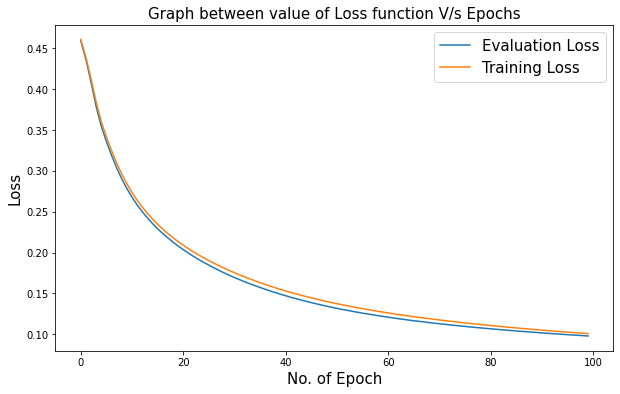



__________________________________________________




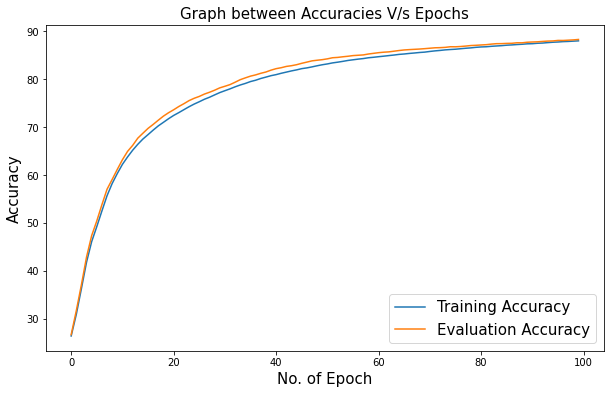

In [22]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

**Observation-** 

**We see that accuracy is still increasing, so we increase the learning rate.**

In [27]:
net = Network([784, 28, 10], cost=QuadraticCost)
epochs = 100
mini_batch_size = 10
eta = 0.1
lmbda = 0
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete

Epoch 5 training complete

Epoch 6 training complete

Epoch 7 training complete

Epoch 8 training complete

Epoch 9 training complete

Epoch 10 training complete

Epoch 11 training complete

Epoch 12 training complete

Epoch 13 training complete

Epoch 14 training complete

Epoch 15 training complete

Epoch 16 training complete

Epoch 17 training complete

Epoch 18 training complete

Epoch 19 training complete

Epoch 20 training complete

Epoch 21 training complete

Epoch 22 training complete

Epoch 23 training complete

Epoch 24 training complete

Epoch 25 training complete

Epoch 26 training complete

Epoch 27 training complete

Epoch 28 training complete

Epoch 29 training complete

Epoch 30 training complete

Epoch 31 training complete

Epoch 32 training complete

Epoch 33 training complete

Epoch 34 training complete

Epoch 35 training complete

Ep

In [28]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.339190,46.892,0.336631,47.46
1,1,0.247467,65.542,0.243426,66.24
2,2,0.198478,74.860,0.193954,75.33
3,3,0.164524,79.852,0.158409,80.78
4,4,0.145548,82.246,0.139749,83.04
...,...,...,...,...,...
95,95,0.043142,94.874,0.051744,93.67
96,96,0.043082,94.850,0.051687,93.63
97,97,0.042826,94.896,0.051649,93.71
98,98,0.042639,94.902,0.051402,93.74


**After increasing the Eta from 0.01 to 0.1, the final accuracy we are hitting is 93.76%**

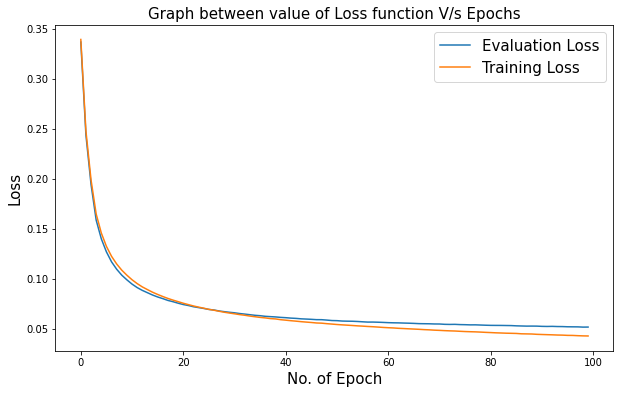



__________________________________________________




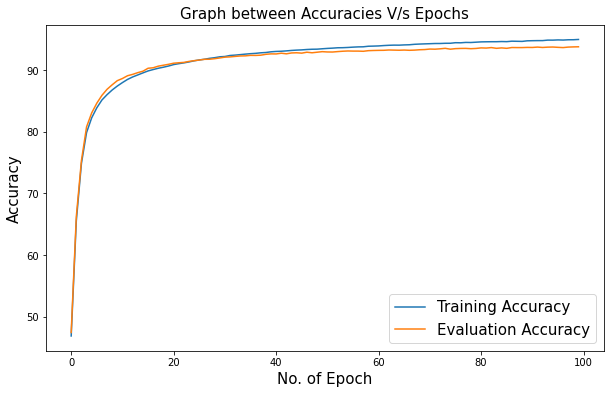

In [29]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

# **Computing for different values of Eta-**

In [11]:
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True

In [20]:
net = Network([784, 28, 10], cost=QuadraticCost)
epochs = 100
mini_batch_size = 10
eta = [0.5,0.9,3,6,9]
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_1 = []
eval_acc_list_1 = []
train_cost_list_1 = []
train_acc_list_1 = []
for i in range(len(eta)):
  net.large_weight_initializer()
  print("Calculations for the eta value =",eta[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta[i], lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_1.append(eval_cost)
  eval_acc_list_1.append(eval_acc)
  train_cost_list_1.append(train_cost)
  train_acc_list_1.append(train_acc)
  print(dash)

Calculations for the eta value = 0.5 

Epoch 0 training complete

Accuracy on evaluation data: 7544 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 7965 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8105 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 8212 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 8267 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 8313 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 8342 / 10000
_________________________________________________________________

Epoch 7 t

**Graph between values of Validation Accuracy And Training Accuracy V/s Epochs for different values of Eta**

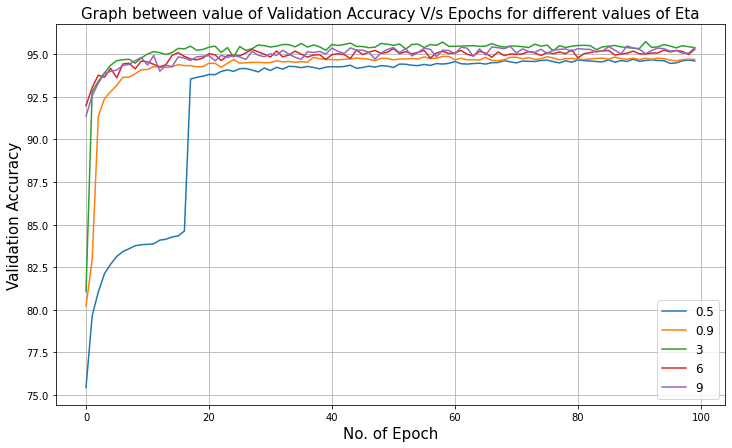



__________________________________________________




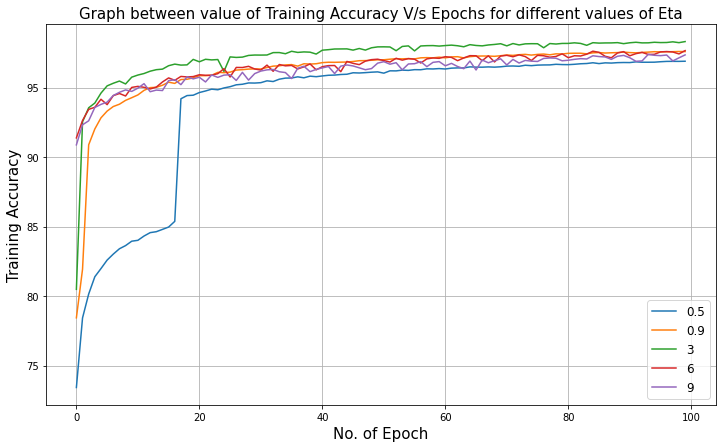

In [34]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_1)):
    plt.plot(eval_acc_list_1[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.5,0.9,3,6,9],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_1)):
    plt.plot(train_acc_list_1[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.5,0.9,3,6,9],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()

**Graph between values of Validation Loss and Training V/s Epochs for different values of Eta**

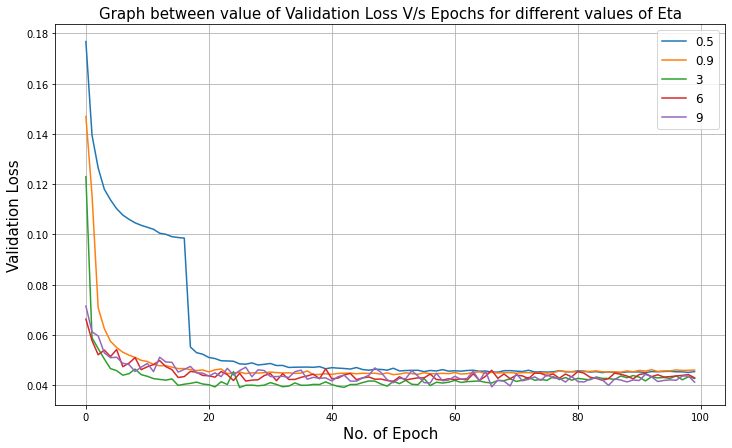



__________________________________________________




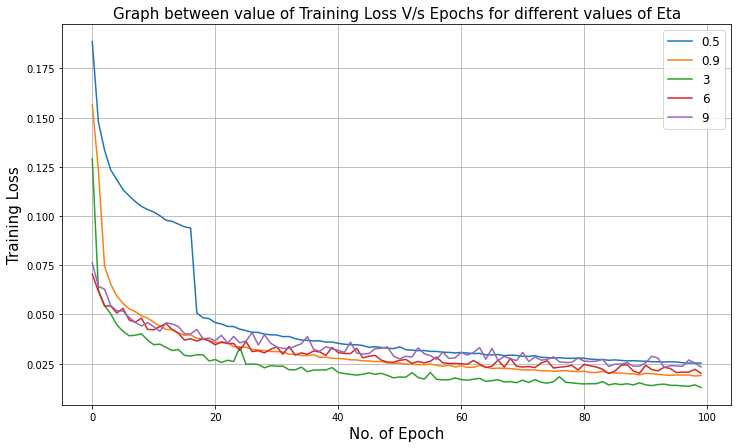

In [35]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_1)):
    plt.plot(eval_cost_list_1[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.5,0.9,3,6,9],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_1)):
    plt.plot(train_cost_list_1[i],label = "Training Loss")
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0.5,0.9,3,6,9],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Eta",fontsize = 15)
plt.grid()
plt.show()

**Printing the final values of Validation accuracy for every Eta value-**

In [38]:
for i in range(len(eta)):
  print("The final validation accuracy for ",eta[i],"Eta value is =",eval_acc_list_1[-len(eta)+i][-1],"\n")

The final validation accuracy for  0.5 Eta value is = 94.6 

The final validation accuracy for  0.9 Eta value is = 94.69 

The final validation accuracy for  3 Eta value is = 95.38 

The final validation accuracy for  6 Eta value is = 95.28999999999999 

The final validation accuracy for  9 Eta value is = 95.37 



**Observation-** 

**We are getting maximum accuracy at an Eta value of 3. So, we will take Eta value as 3 for the calculations ahead.**

**We also observe that for Eta value 3, the accuracy gets maximum at around 20 epochs only, and from there, it remains somewhat constant. So, we can take the value of Iterations to 30 for calculations ahead.** 

# **Computing for different values of mini batch size-**

In [40]:
net = Network([784, 28, 10], cost=QuadraticCost)
epochs = 30
mini_batch_size = [5,10,20,50,100,200]
eta = 3
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_2 = []
eval_acc_list_2 = []
train_cost_list_2 = []
train_acc_list_2 = []
for i in range(len(mini_batch_size)):
  net.large_weight_initializer()
  print("Calculations for the mini batch size value =",mini_batch_size[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size[i], eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_2.append(eval_cost)
  eval_acc_list_2.append(eval_acc)
  train_cost_list_2.append(train_cost)
  train_acc_list_2.append(train_acc)
  print(dash)

Calculations for the mini batch size value = 5 

Epoch 0 training complete

Accuracy on evaluation data: 9098 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9284 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9371 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9392 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9430 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9405 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9437 / 10000
_________________________________________________________________


**Graph between value of Validation Accuracy and Training Accuracy V/s Epochs for different values of Mini batch size**

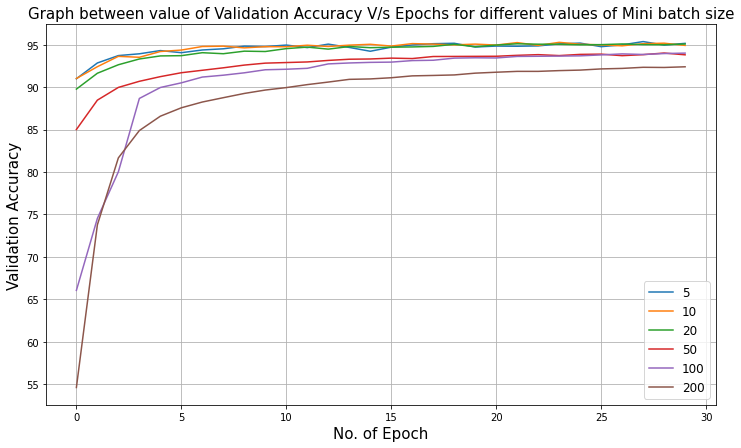



__________________________________________________




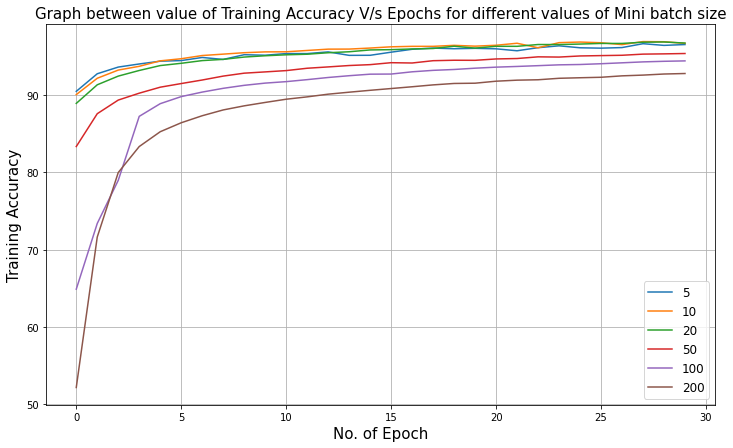

In [41]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_2)):
    plt.plot(eval_acc_list_2[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([5,10,20,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_2)):
    plt.plot(train_acc_list_2[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([5,10,20,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()

**Graph between value of Validation Loss and Training Loss V/s Epochs for different values of Mini batch size**

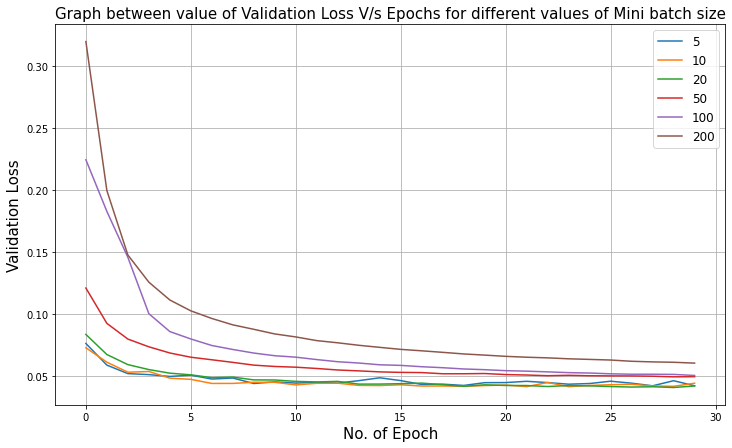



__________________________________________________




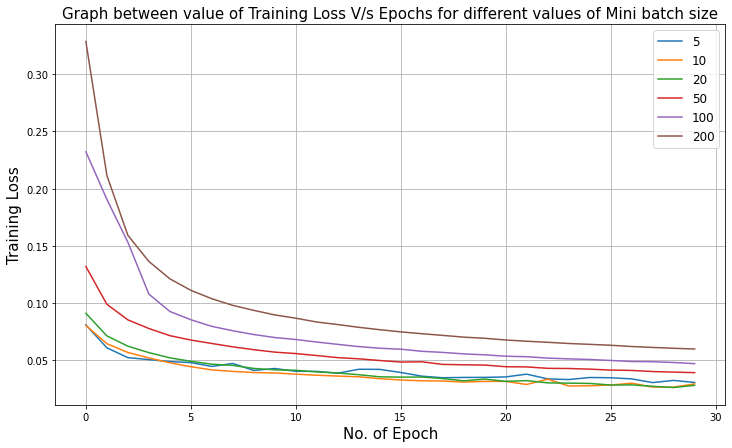

In [42]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_2)):
    plt.plot(eval_cost_list_2[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([5,10,20,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_2)):
    plt.plot(train_cost_list_2[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([5,10,20,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()

**Printing the final values of Validation accuracy for every Mini batch size value-**

In [44]:
for i in range(len(mini_batch_size)):
  print("The final validation accuracy for ",mini_batch_size[i],"Mini batch size value is =",eval_acc_list_2[-len(mini_batch_size)+i][-1],"\n")  

The final validation accuracy for  5 Mini batch size value is = 95.15 

The final validation accuracy for  10 Mini batch size value is = 94.91000000000001 

The final validation accuracy for  20 Mini batch size value is = 95.07 

The final validation accuracy for  50 Mini batch size value is = 93.8 

The final validation accuracy for  100 Mini batch size value is = 94.0 

The final validation accuracy for  200 Mini batch size value is = 92.39 



**Now, I also want to see the effect of batch size on accuracy of batch size is 1 and also for batch size of all training data-**

In [46]:
net = Network([784, 28, 10], cost=QuadraticCost)
epochs = 30
mini_batch_size = [1,len(training_data)]
eta = 3
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_2a = []
eval_acc_list_2a = []
train_cost_list_2a = []
train_acc_list_2a = []
for i in range(len(mini_batch_size)):
  net.large_weight_initializer()
  print("Calculations for the mini batch size value =",mini_batch_size[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size[i], eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_2a.append(eval_cost)
  eval_acc_list_2a.append(eval_acc)
  train_cost_list_2a.append(train_cost)
  train_acc_list_2a.append(train_acc)
  print(dash)

Calculations for the mini batch size value = 1 

Epoch 0 training complete

Accuracy on evaluation data: 8309 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 8422 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 8713 / 10000
_________________________________________________________________



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:213: RuntimeWarning: overflow encountered in exp


Epoch 3 training complete

Accuracy on evaluation data: 8821 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 8728 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 8292 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 8792 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluation data: 8701 / 10000
_________________________________________________________________

Epoch 8 training complete

Accuracy on evaluation data: 8605 / 10000
_________________________________________________________________

Epoch 9 training complete

Accuracy on evaluation data: 9038 / 10000
_________________________________________________________________

Epoch 10 training complete

Accuracy on evaluati

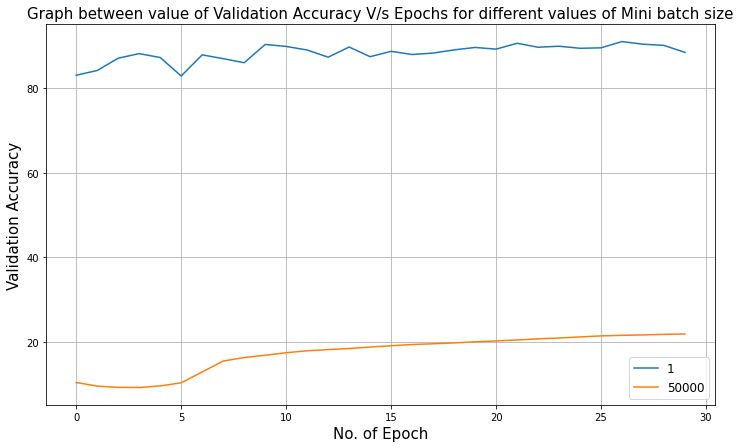



__________________________________________________




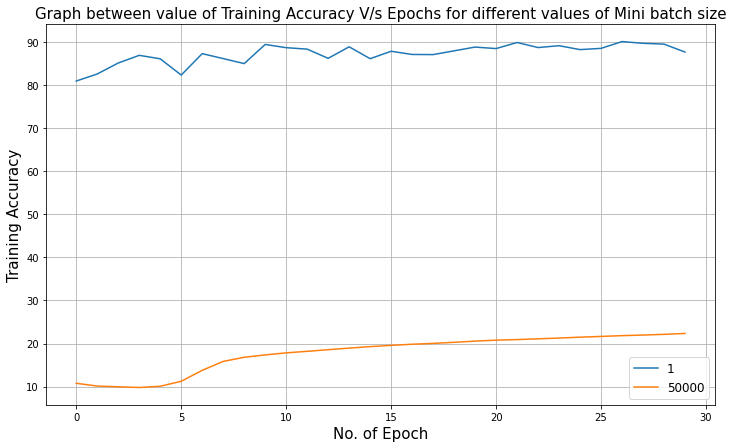



__________________________________________________




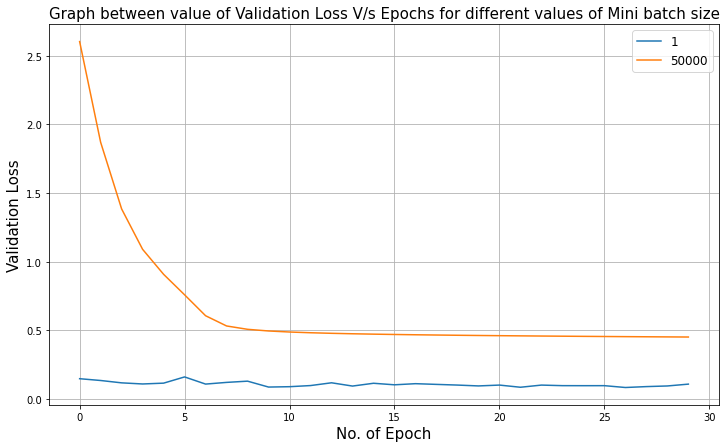



__________________________________________________




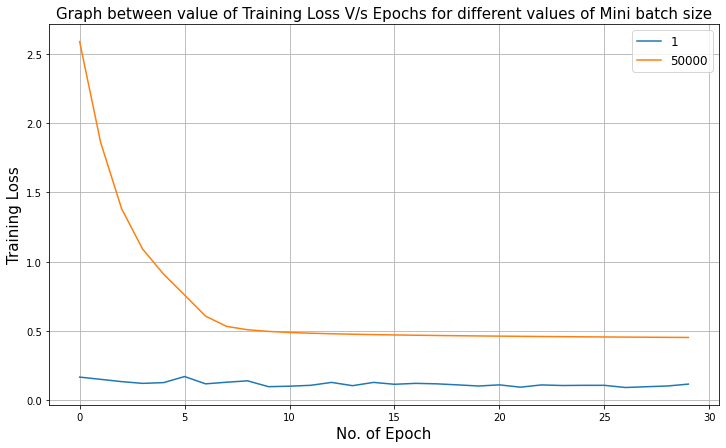

In [52]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_2a)):
    plt.plot(eval_acc_list_2a[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,len(training_data)],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_2a)):
    plt.plot(train_acc_list_2a[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,len(training_data)],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_2a)):
    plt.plot(eval_cost_list_2a[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,len(training_data)],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_2a)):
    plt.plot(train_cost_list_2a[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([1,len(training_data)],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Mini batch size",fontsize = 15)
plt.grid()
plt.show()

**Observation- The maximum accuracy is at batch size of 10.**

# **Computing for different Epoch values-**

In [23]:
net = Network([784, 28, 10], cost=QuadraticCost)
epochs = [20,30,50,100,200]
mini_batch_size = 10
eta = 3
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_3 = []
eval_acc_list_3 = []
train_cost_list_3 = []
train_acc_list_3 = []
for i in range(len(epochs)):
  net.large_weight_initializer()
  print("Calculations for the epochs size value =",epochs[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs[i], mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_3.append(eval_cost)
  eval_acc_list_3.append(eval_acc)
  train_cost_list_3.append(train_cost)
  train_acc_list_3.append(train_acc)
  print(dash)

Calculations for the epochs size value = 20 

Epoch 0 training complete

Accuracy on evaluation data: 9054 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9243 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9332 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9366 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9316 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9406 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9413 / 10000
_________________________________________________________________

Ep

**Graph between value of Validation Accuracy and Training Accuracy V/s Epochs for different values of Epochs Size**

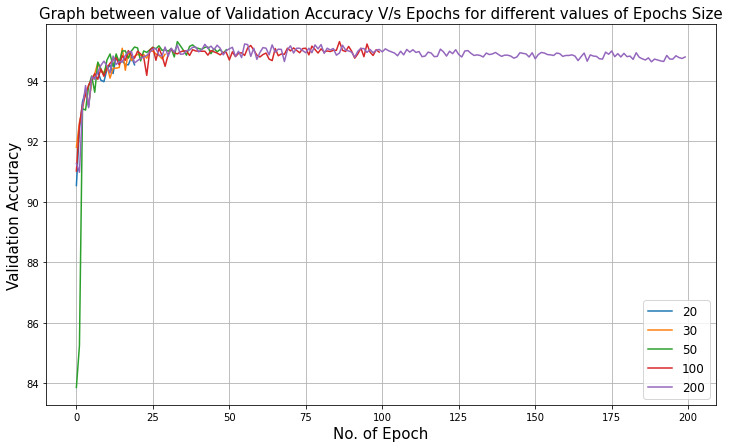



__________________________________________________




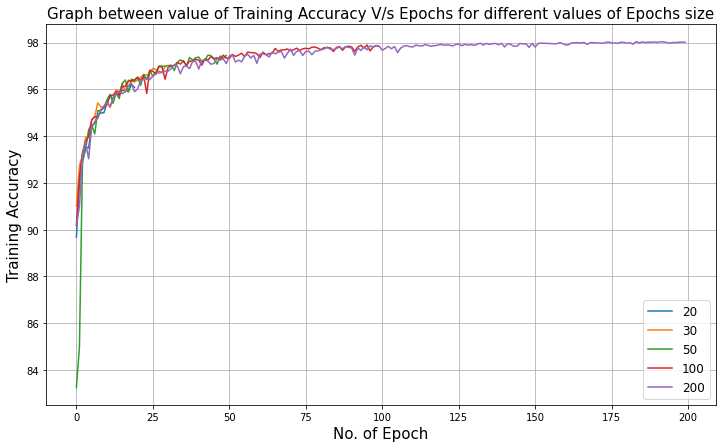

In [24]:
plt.figure(figsize =(12,7))
for i in range(len(eval_acc_list_3)):
    plt.plot(eval_acc_list_3[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([20,30,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_acc_list_3)):
    plt.plot(train_acc_list_3[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([20,30,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Epochs size",fontsize = 15)
plt.grid()
plt.show()

**Graph between value of Validation Loss and Training Loss V/s Epochs for different values of Epochs Size**

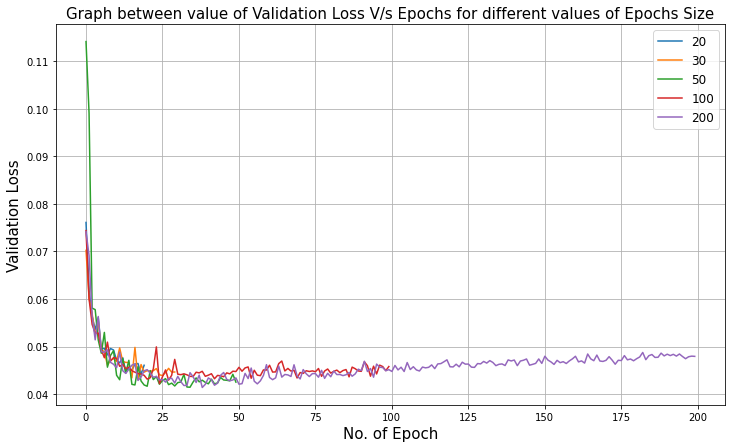



__________________________________________________




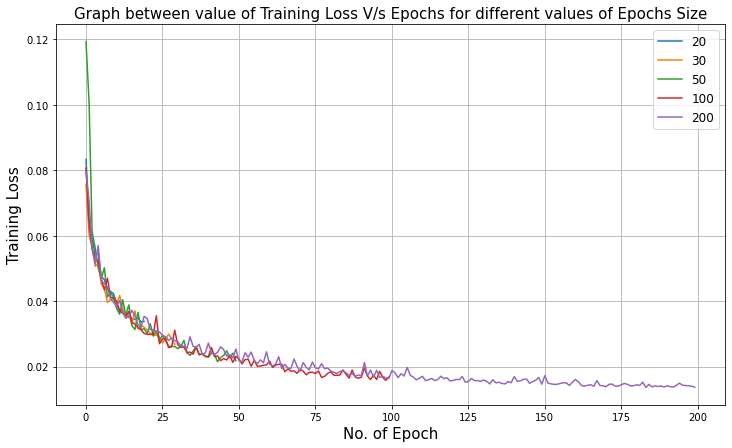

In [25]:
plt.figure(figsize =(12,7))
for i in range(len(eval_cost_list_3)):
    plt.plot(eval_cost_list_3[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([20,30,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(train_cost_list_3)):
    plt.plot(train_cost_list_3[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([20,30,50,100,200],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Epochs Size",fontsize = 15)
plt.grid()
plt.show()

**Printing the final values of Validation accuracy for every Epochs size value-**

In [27]:
for i in range(len(epochs)):
  print("The final validation accuracy for ",epochs[i],"Epochs size value is =",eval_acc_list_3[-len(epochs)+i][-1],"\n")  

The final validation accuracy for  20 Epochs size value is = 94.54 

The final validation accuracy for  30 Epochs size value is = 94.89 

The final validation accuracy for  50 Epochs size value is = 95.04 

The final validation accuracy for  100 Epochs size value is = 94.96 

The final validation accuracy for  200 Epochs size value is = 94.8 



# **Now, We increase the hidden layers-**

In [ ]:
net = Network([784,28,15, 10], cost=QuadraticCost)
epochs = 100
mini_batch_size = 10
eta = 3
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_312 = []
eval_acc_list_312 = []
train_cost_list_312 = []
train_acc_list_312 = []
net.large_weight_initializer()
print("Calculations for the epochs size value =",epochs,"\n")
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
eval_cost_list_312.append(eval_cost)
eval_acc_list_312.append(eval_acc)
train_cost_list_312.append(train_cost)
train_acc_list_312.append(train_acc)
print(dash)

In [29]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.084050,89.578,0.083671,89.66
1,1,0.063624,91.964,0.065316,91.62
2,2,0.055870,93.006,0.056649,92.88
3,3,0.069660,91.274,0.072747,90.92
4,4,0.047310,94.154,0.049892,93.83
...,...,...,...,...,...
95,95,0.016838,98.010,0.041037,95.18
96,96,0.016195,98.074,0.040189,95.30
97,97,0.020416,97.522,0.041954,95.04
98,98,0.015115,98.208,0.039101,95.41


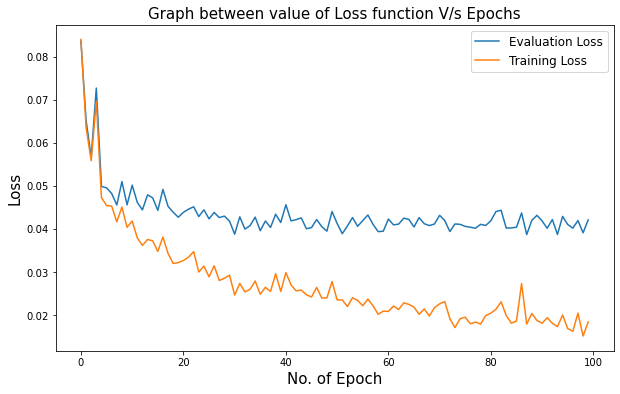



__________________________________________________




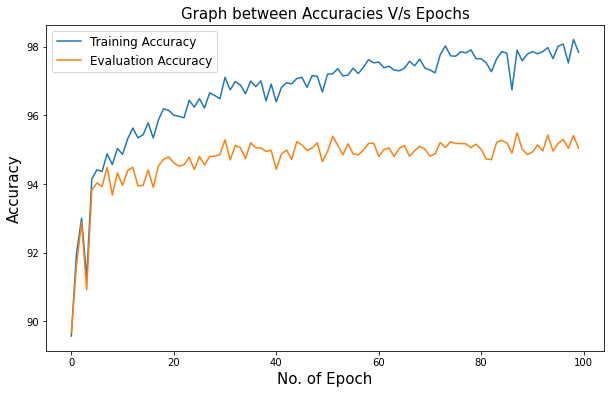

In [30]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

**Now, further increasing the hidden layers and see what happens-**

In [14]:
net = Network([784, 28,28,28,15, 10], cost=QuadraticCost)
epochs = 100
mini_batch_size = 10
eta = 3
lmbda = 0
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_31 = []
eval_acc_list_31 = []
train_cost_list_31 = []
train_acc_list_31 = []
net.large_weight_initializer()
print("Calculations for the epochs size value =",epochs,"\n")
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
eval_cost_list_31.append(eval_cost)
eval_acc_list_31.append(eval_acc)
train_cost_list_31.append(train_cost)
train_acc_list_31.append(train_acc)
print(dash)

Calculations for the epochs size value = 100 

Epoch 0 training complete

Accuracy on evaluation data: 8945 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9087 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9216 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9220 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9302 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9376 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9330 / 10000
_________________________________________________________________

E

In [15]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.090355,88.792,0.085155,89.45
1,1,0.077360,90.324,0.072722,90.87
2,2,0.066356,91.882,0.064245,92.16
3,3,0.062656,92.220,0.063814,92.20
4,4,0.058252,92.760,0.056897,93.02
...,...,...,...,...,...
95,95,0.030124,96.420,0.040555,95.24
96,96,0.025911,96.956,0.038921,95.42
97,97,0.025937,96.892,0.038270,95.20
98,98,0.026849,96.676,0.039515,95.15


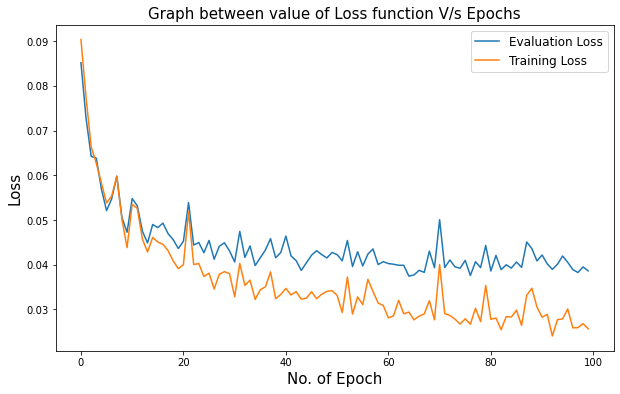



__________________________________________________




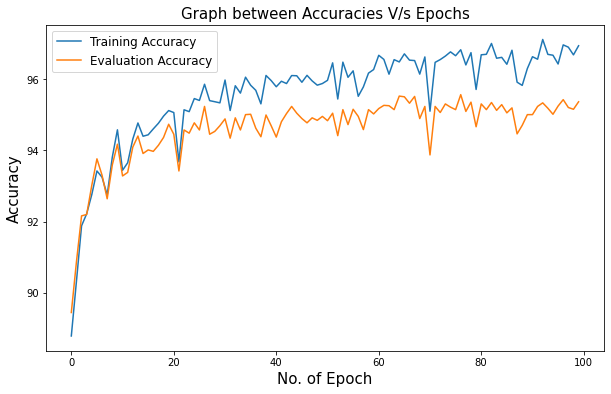

In [16]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

**The accuracy does not increase and remains somewhat constant**

# Now, we introduce L2 regularisation-

# We fix the number of epochs to 50, Eta to be 3 and mini batch size to 10, and see the results for different values of the parameter lambda-

In [31]:
net = Network([784, 28, 10], cost=QuadraticCost)
epochs = 50
mini_batch_size = 10
eta = 3
lmbda = [0,0.1,0.2,0.5,0.8,1]
evaluation_data = validation_data
dash = "_____________________________________________________________"
eval_cost_list_4 = []
eval_acc_list_4 = []
train_cost_list_4 = []
train_acc_list_4 = []
for i in range(len(lmbda)):
  net.large_weight_initializer()
  print("Calculations for the lambda value =",lmbda[i],"\n")
  eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda[i],evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)
  eval_cost_list_4.append(eval_cost)
  eval_acc_list_4.append(eval_acc)
  train_cost_list_4.append(train_cost)
  train_acc_list_4.append(train_acc)
  print(dash)

Calculations for the lambda value = 0 

Epoch 0 training complete

Accuracy on evaluation data: 9016 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9282 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9324 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9389 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9377 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9396 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9399 / 10000
_________________________________________________________________

Epoch 7 

**Graph between value of Validation Accuracy and Training Accuracy V/s Epochs for different values of Lambda**

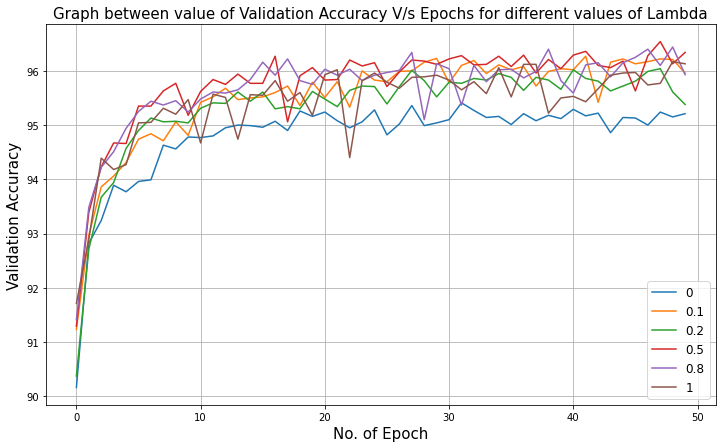



__________________________________________________




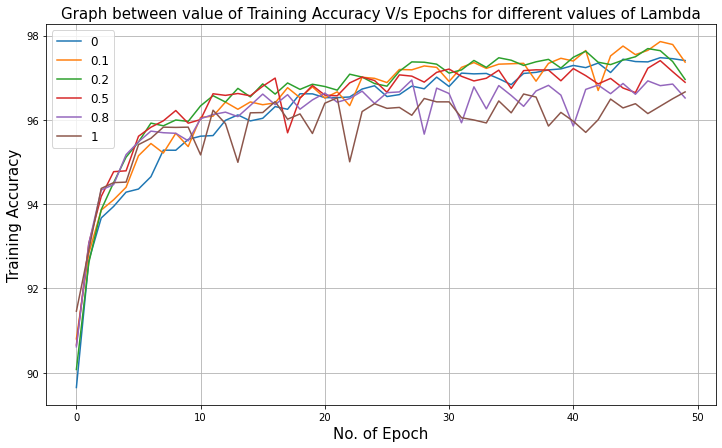

In [32]:
plt.figure(figsize =(12,7))
for i in range(len(lmbda)):
    plt.plot(eval_acc_list_4[i])
plt.ylabel("Validation Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0,0.1,0.2,0.5,0.8,1],loc='best',fontsize=12)
plt.title("Graph between value of Validation Accuracy V/s Epochs for different values of Lambda",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(lmbda)):
    plt.plot(train_acc_list_4[i])
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0,0.1,0.2,0.5,0.8,1],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different values of Lambda",fontsize = 15)
plt.grid()
plt.show()

**Graph between value of Validation Loss and Training Loss V/s Epochs for different values of Lambda**

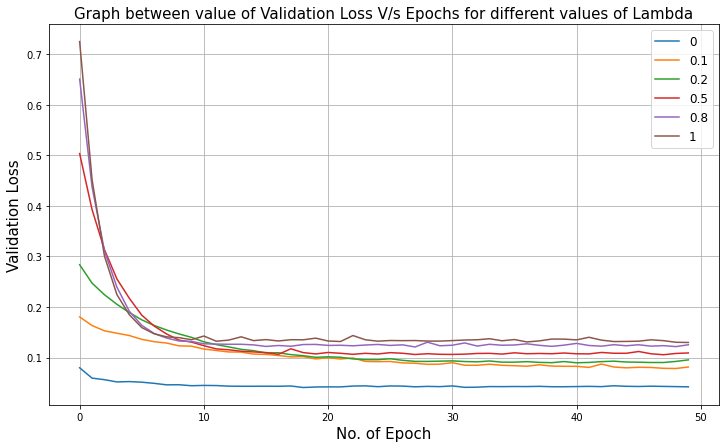



__________________________________________________




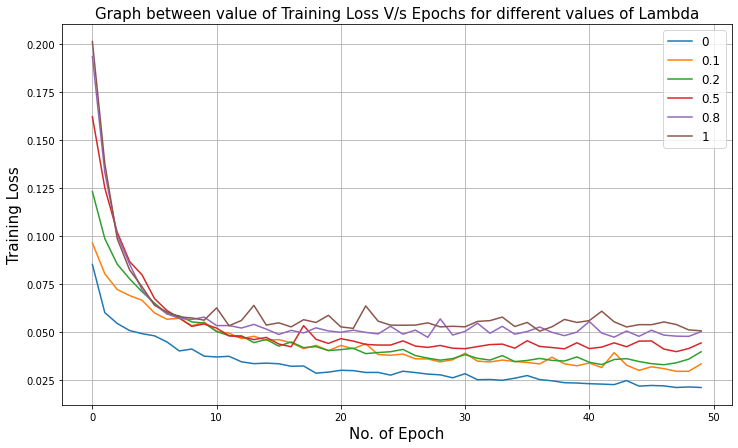

In [33]:
plt.figure(figsize =(12,7))
for i in range(len(lmbda)):
    plt.plot(eval_cost_list_4[i])
plt.ylabel("Validation Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0,0.1,0.2,0.5,0.8,1],loc='best',fontsize=12)
plt.title("Graph between value of Validation Loss V/s Epochs for different values of Lambda",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
for i in range(len(lmbda)):
    plt.plot(train_cost_list_4[i])
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend([0,0.1,0.2,0.5,0.8,1],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different values of Lambda",fontsize = 15)
plt.grid()
plt.show()

In [34]:
for i in range(len(lmbda)):
  print("The final validation accuracy for ",lmbda[i],"Lambda value is =",eval_acc_list_4[-len(lmbda)+i][-1],"\n")  

The final validation accuracy for  0 Lambda value is = 95.21 

The final validation accuracy for  0.1 Lambda value is = 95.96000000000001 

The final validation accuracy for  0.2 Lambda value is = 95.38 

The final validation accuracy for  0.5 Lambda value is = 96.34 

The final validation accuracy for  0.8 Lambda value is = 95.93 

The final validation accuracy for  1 Lambda value is = 96.13000000000001 



**The best performance we are getting is on the Lambda value of 0.5**

# Now, training the neural network with the values of hyperparameters that we got and evaluating the performance on testing data-

Epochs - 50
Mini batch size = 10
Eta = 3
Lambda = 0.5

In [35]:
net = Network([784, 28,10], cost=QuadraticCost)
epochs = 50
mini_batch_size = 10
eta = 3
lmbda = 0.5
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.large_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 8918 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9144 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9247 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9351 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9400 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9410 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9444 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [36]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.172669,89.122,0.516822,89.18
1,1,0.132185,91.964,0.402846,91.44
2,2,0.113998,92.604,0.326898,92.47
3,3,0.092946,94.004,0.265731,93.51
4,4,0.081775,94.624,0.224465,94.00
5,5,0.071587,95.058,0.193674,94.10
6,6,0.064777,95.352,0.171406,94.44
7,7,0.065385,94.964,0.159438,94.24
8,8,0.060008,95.322,0.147181,94.37
9,9,0.054290,95.930,0.135550,94.80


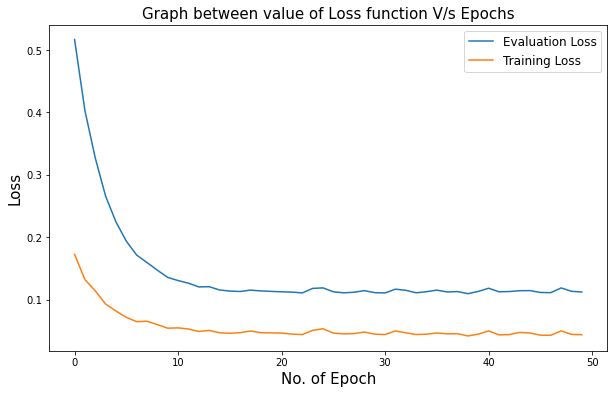



__________________________________________________




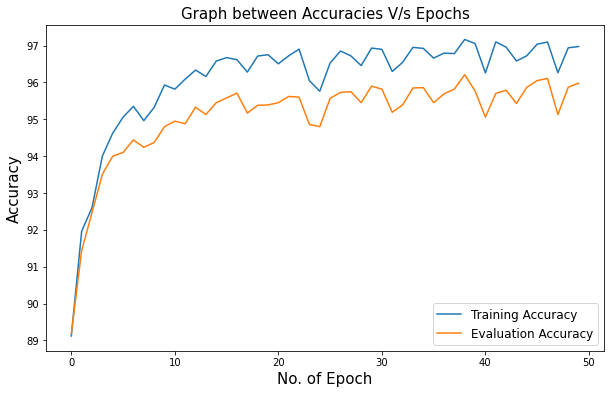

In [37]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

In [40]:
eval_cost_without_wt = eval_cost
eval_acc_without_wt = eval_acc
train_cost_without_wt = train_cost 
train_acc_without_wt = train_acc

# Now, we introduce weight initialisation-

In [41]:
net = Network([784, 28,10], cost=QuadraticCost)
epochs = 50
mini_batch_size = 10
eta = 3
lmbda = 0.5
evaluation_data = test_data
monitor_evaluation_cost = True
monitor_evaluation_accuracy = True
monitor_training_cost = True
monitor_training_accuracy = True
net.default_weight_initializer()
eval_cost,eval_acc,train_cost,train_acc = net.SGD(training_data, epochs, mini_batch_size, eta, lmbda,evaluation_data,monitor_evaluation_cost, monitor_evaluation_accuracy,monitor_training_cost, monitor_training_accuracy)

Epoch 0 training complete

Accuracy on evaluation data: 9397 / 10000
_________________________________________________________________

Epoch 1 training complete

Accuracy on evaluation data: 9449 / 10000
_________________________________________________________________

Epoch 2 training complete

Accuracy on evaluation data: 9475 / 10000
_________________________________________________________________

Epoch 3 training complete

Accuracy on evaluation data: 9504 / 10000
_________________________________________________________________

Epoch 4 training complete

Accuracy on evaluation data: 9555 / 10000
_________________________________________________________________

Epoch 5 training complete

Accuracy on evaluation data: 9541 / 10000
_________________________________________________________________

Epoch 6 training complete

Accuracy on evaluation data: 9529 / 10000
_________________________________________________________________

Epoch 7 training complete

Accuracy on evaluatio

In [42]:
df = TabularFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)
df

,Epoch Value,Training Loss,Training Accuracy,Evaluation loss,Evaluation Accuracy
0,0,0.056001,94.134,0.085512,93.97
1,1,0.054616,94.766,0.093833,94.49
2,2,0.050837,95.340,0.096940,94.75
3,3,0.048652,95.778,0.099758,95.04
4,4,0.047760,96.022,0.100596,95.55
5,5,0.048491,96.052,0.103453,95.41
6,6,0.049266,95.976,0.105404,95.29
7,7,0.046026,96.536,0.104782,95.74
8,8,0.044426,96.626,0.103638,95.67
9,9,0.046554,96.502,0.106333,95.54


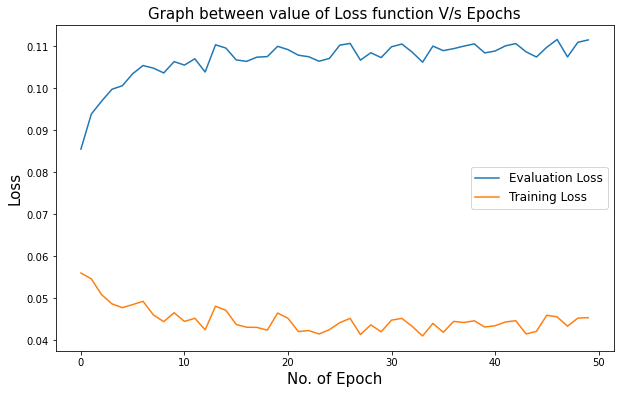



__________________________________________________




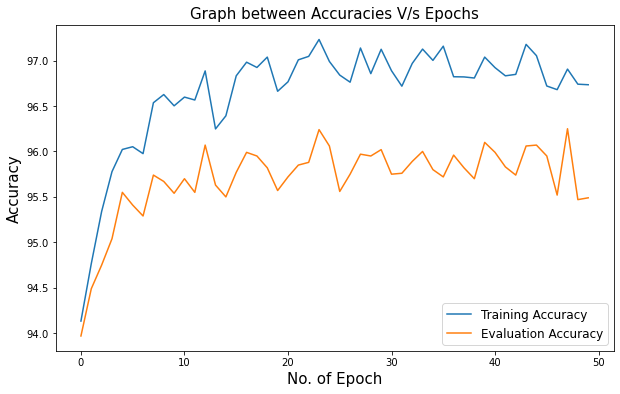

In [43]:
GraphicalFormat(epochs,eval_cost,eval_acc,train_cost,train_acc)

In [44]:
eval_cost_with_wt = eval_cost
eval_acc_with_wt = eval_acc
train_cost_with_wt = train_cost 
train_acc_with_wt = train_acc

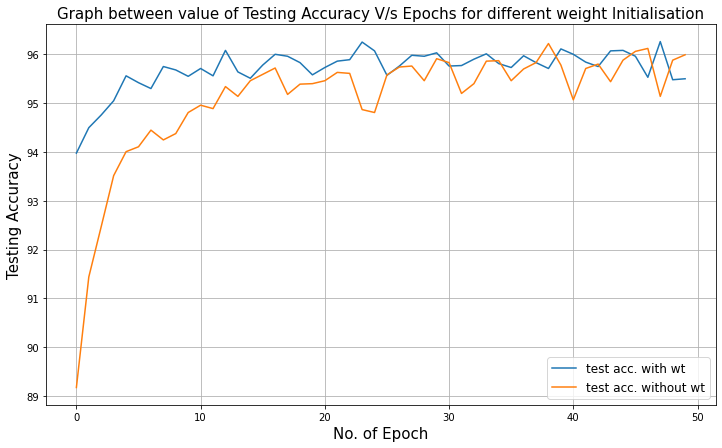



__________________________________________________




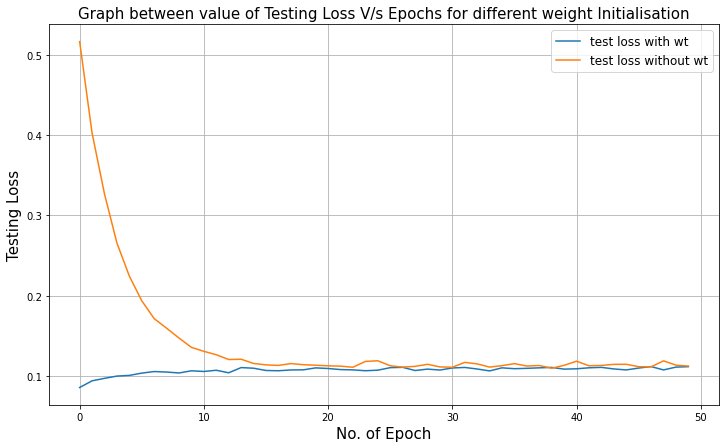



__________________________________________________




In [47]:
plt.figure(figsize =(12,7))
plt.plot(eval_acc_with_wt)
plt.plot(eval_acc_without_wt)
plt.ylabel("Testing Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend(["test acc. with wt","test acc. without wt"],loc='best',fontsize=12)
plt.title("Graph between value of Testing Accuracy V/s Epochs for different weight Initialisation",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
plt.plot(eval_cost_with_wt)
plt.plot(eval_cost_without_wt)
plt.ylabel("Testing Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend(["test loss with wt","test loss without wt"],loc='best',fontsize=12)
plt.title("Graph between value of Testing Loss V/s Epochs for different weight Initialisation",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

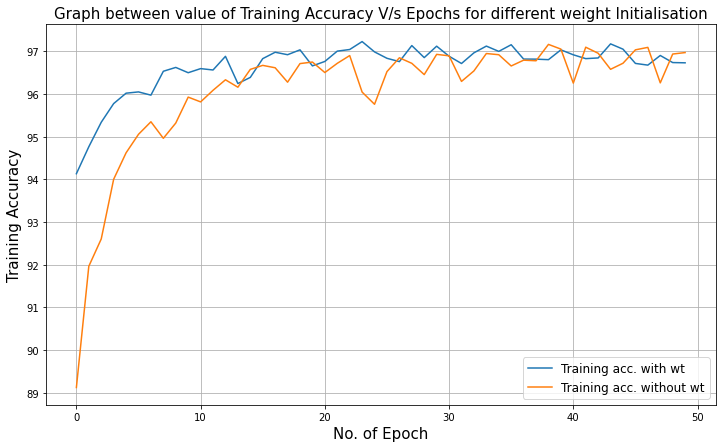



__________________________________________________




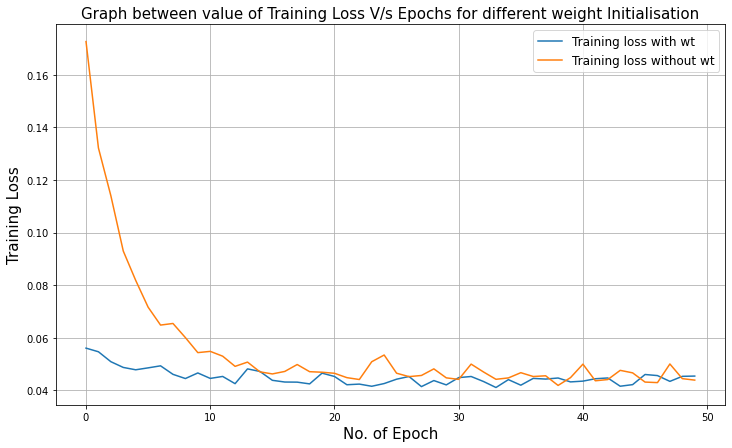



__________________________________________________




In [48]:
plt.figure(figsize =(12,7))
plt.plot(train_acc_with_wt)
plt.plot(train_acc_without_wt)
plt.ylabel("Training Accuracy",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend(["Training acc. with wt","Training acc. without wt"],loc='best',fontsize=12)
plt.title("Graph between value of Training Accuracy V/s Epochs for different weight Initialisation",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")

plt.figure(figsize =(12,7))
plt.plot(train_cost_with_wt)
plt.plot(train_cost_without_wt)
plt.ylabel("Training Loss",fontsize = 15)
plt.xlabel("No. of Epoch",fontsize = 15)
plt.legend(["Training loss with wt","Training loss without wt"],loc='best',fontsize=12)
plt.title("Graph between value of Training Loss V/s Epochs for different weight Initialisation",fontsize = 15)
plt.grid()
plt.show()
print("\n\n__________________________________________________\n\n")